In [1]:
from ktms import *
from MAInit import *
from MACalc import *
import re
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from pymongo import MongoClient
client = MongoClient()
client = MongoClient('localhost', 27017)

In [3]:
db = client.adsE_database
collection = db.adsE_collection

In [4]:
dictlis = [{'element':'Cu', 'mirror':'100', 'moved+':'no', 'moved':'no'},
           {'element':'Cu', 'mirror':'111', 'moved+':'no', 'moved':'no'},
           {'element':'Ag', 'mirror':'100', 'moved+':'no', 'moved':'no'},
           {'element':'Ag', 'mirror':'111', 'moved+':'no', 'moved':'no'},
           {'element':'Pt', 'mirror':'100', 'moved+':'no', 'moved':'no'},
           {'element':'Pt', 'mirror':'111', 'moved+':'no', 'moved':'no'},
           {'element':'NiGa', 'mirror':'110', 'moved+':'no', 'moved':'no'},
           {'element':'CoPt3', 'mirror':'100', 'moved+':'no', 'moved':'no'},
          ]

results = []
for dic in dictlis:
    tmp = []
    for post in collection.find(dic):
        tmp.append(post)
    results.append(tmp)

df = []

for i in range(len(results)):
    df.append(pd.DataFrame(results[i]))

In [5]:
### Exclude coverage > 1.0 ###
for i in range(len(df)):
    df[i] = df[i][df[i]['coverage'] <= 1]

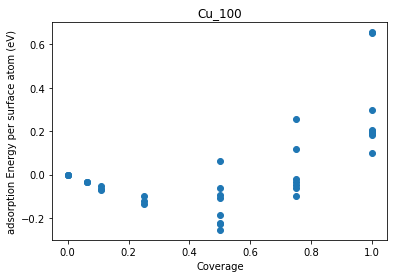

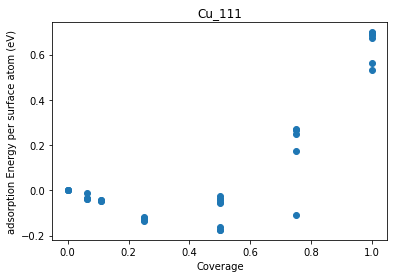

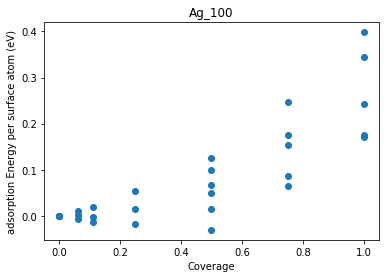

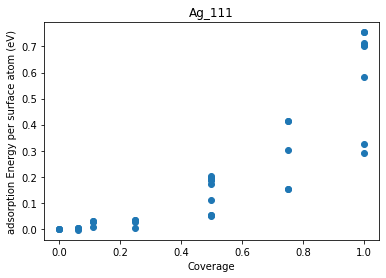

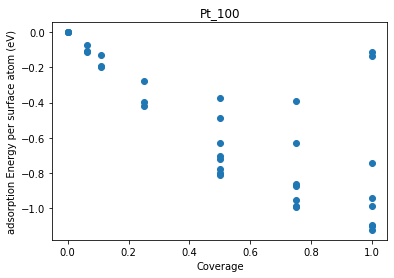

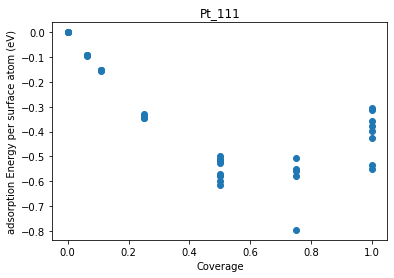

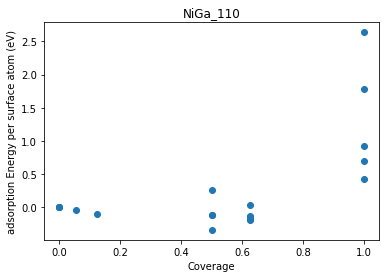

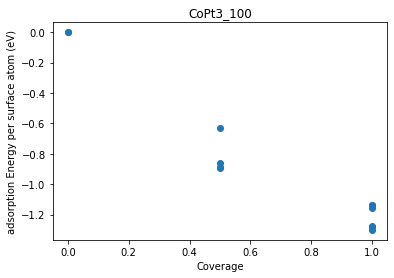

In [6]:
for i in range(len(df)):
    plt.plot(df[i]['coverage'], df[i]['aveadsEne/suratom'], 'o')
    plt.title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    plt.xlabel('Coverage')
    plt.ylabel('adsorption Energy per surface atom (eV)')
#     plt.savefig('{}_{}_ene_ML.png'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    plt.show()

In [7]:
covset = []
for i in range(len(df)):
    covset.append(sorted(list(set(df[i]['coverage']))))
covset

[[0.0, 0.0625, 0.1111111111111111, 0.25, 0.5, 0.75, 1.0],
 [0.0, 0.0625, 0.1111111111111111, 0.25, 0.5, 0.75, 1.0],
 [0.0, 0.0625, 0.1111111111111111, 0.25, 0.5, 0.75, 1.0],
 [0.0, 0.0625, 0.1111111111111111, 0.25, 0.5, 0.75, 1.0],
 [0.0, 0.0625, 0.1111111111111111, 0.25, 0.5, 0.75, 1.0],
 [0.0, 0.0625, 0.1111111111111111, 0.25, 0.5, 0.75, 1.0],
 [0.0, 0.05555555555555555, 0.125, 0.5, 0.625, 1.0],
 [0.0, 0.5, 1.0]]

In [8]:
eneset = copy.deepcopy(covset)
for i in range(len(covset)):
    for j in range(len(covset[i])):
        eneset[i][j] = df[i][df[i]['coverage'] == covset[i][j]]['aveadsEne/suratom'].min()

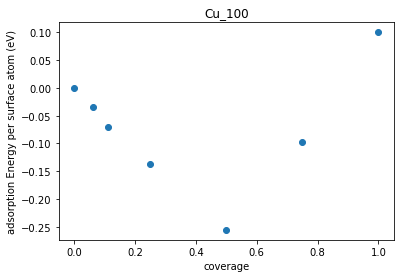

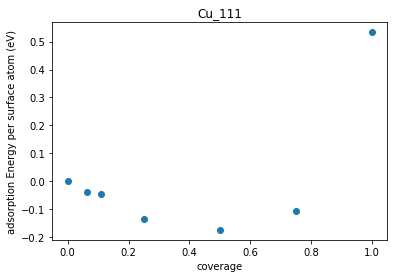

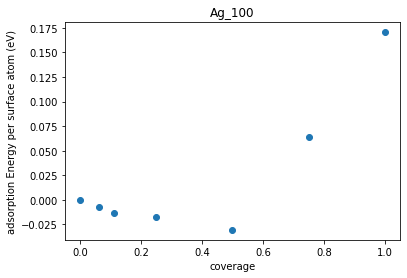

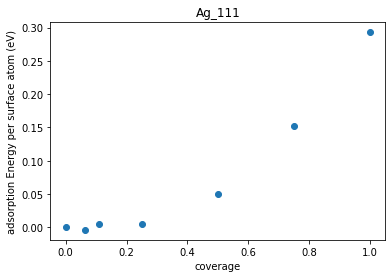

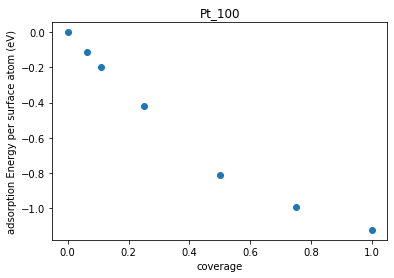

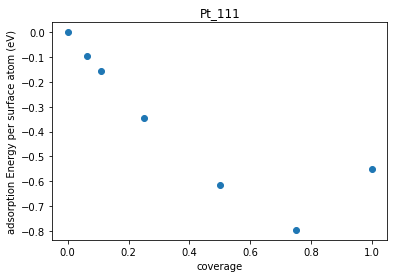

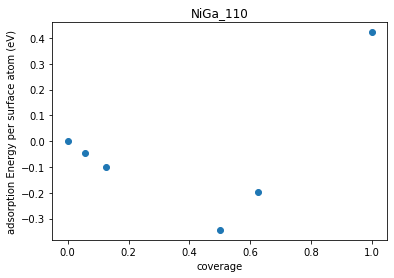

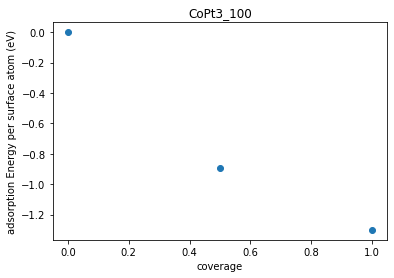

In [9]:
for i in range(len(df)):
    plt.plot(covset[i], eneset[i], 'o')
    plt.title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    plt.xlabel('coverage')
    plt.ylabel('adsorption Energy per surface atom (eV)')
    plt.show()

In [10]:
kb = 8.62E-05 # eV/K
T = 298 # K
Pref = 1 # bar

In [11]:
prange = [0.01, 0.1, 1, 10, 100, 1000]
pres = []

for i in range(len(eneset)):
    tmp = []
    for p in prange:
        tmp.append(eneset[i]-kb*T*np.log(p/Pref)*np.array(covset[i]))
    pres.append(tmp)

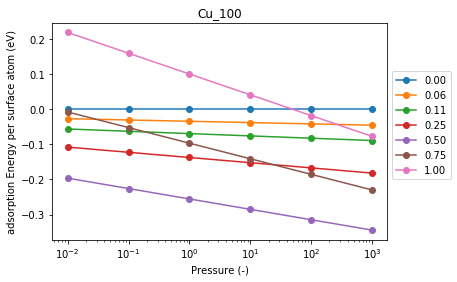

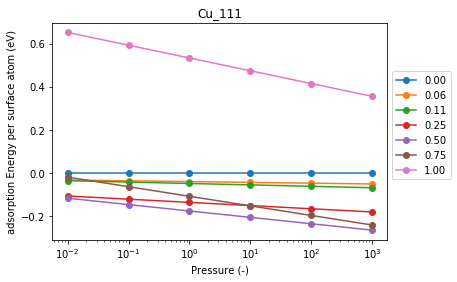

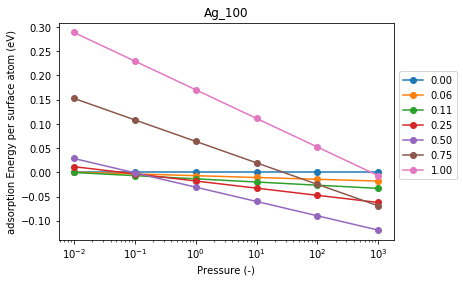

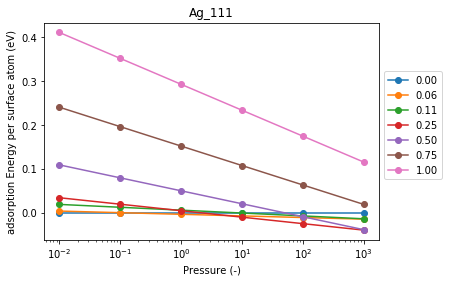

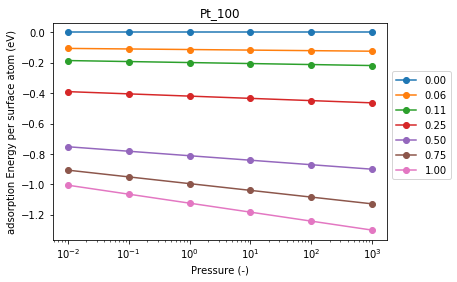

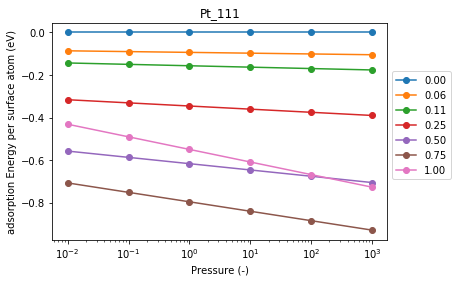

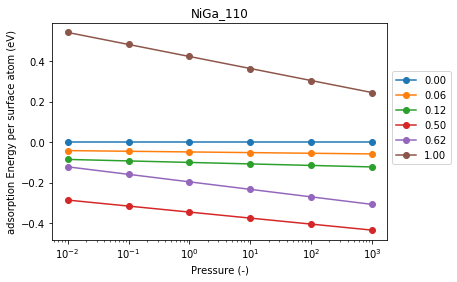

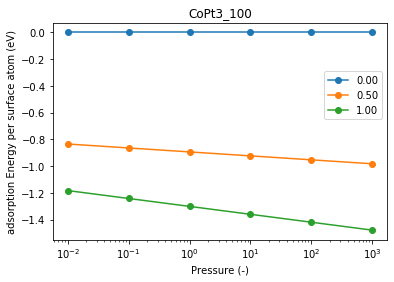

In [12]:
for i in range(len(pres)):
    plt.plot(prange, pres[i], 'o-')
    plt.xscale('log')
    plt.title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    plt.xlabel('Pressure (-)')
    plt.ylabel('adsorption Energy per surface atom (eV)')
    plt.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
#     plt.savefig('{}_{}_pourbaix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.show()

In [13]:
from sklearn.linear_model import LinearRegression
Lin = LinearRegression()

def linearfit(X, y):
    index = np.argmin(y)
    Lin.fit(X[:index+1], y[:index+1])
    y_pred = Lin.predict(X)
    slope = Lin.coef_
    return y_pred, slope

[-0.50709709]


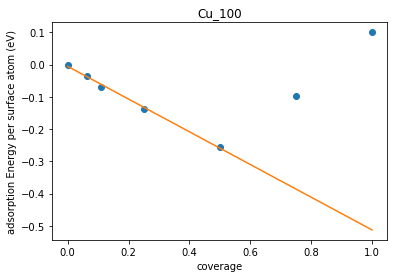

[-0.35281016]


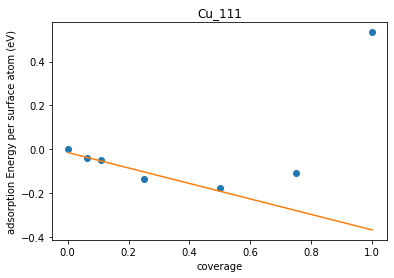

[-0.0566626]


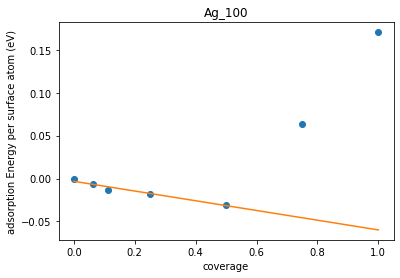

[-0.06043151]


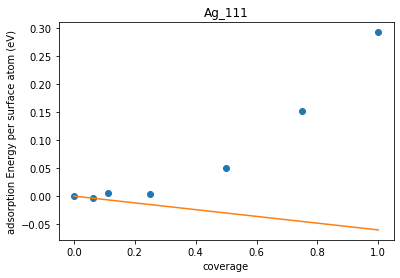

[-1.1624863]


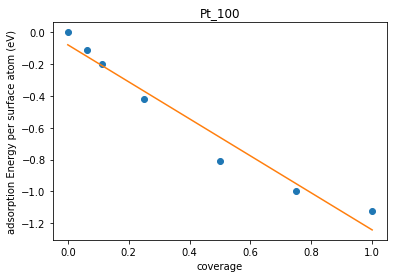

[-1.07134376]


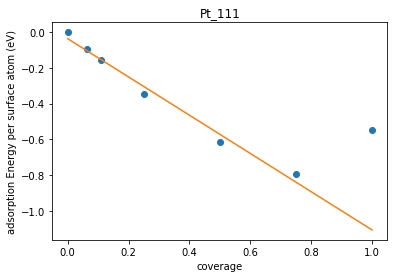

[-0.67648349]


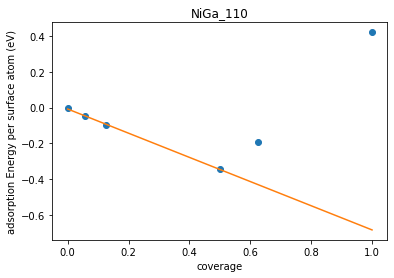

[-1.30089291]


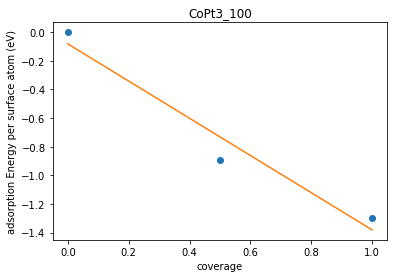

In [14]:
for i in range(len(eneset)):
    X, y = (list(x) for x in zip(*sorted(zip(covset[i], eneset[i]))))
    X = np.array(X)
    y = np.array(y)    
    X = X.reshape(-1, 1)
    fitres, slope = linearfit(X, y)

    print(slope)
    plt.plot(X, y, 'o')
    plt.plot(X, fitres, '-')
    plt.title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    plt.xlabel('coverage')
    plt.ylabel('adsorption Energy per surface atom (eV)')
#     plt.savefig('{}_{}_fit.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.show()

In [15]:
def linearfit2(X, y):
    index = 1
    Lin.fit(X[:index+1], y[:index+1])
    y_pred = Lin.predict(X)
    slope = Lin.coef_
    return y_pred, slope

In [16]:
densityset = []
for i in range(len(covset)):
    densityset.append(covset[i]/df[i][df[i]['unitlength'] ==1]['area'][0])

[-3.72801964]


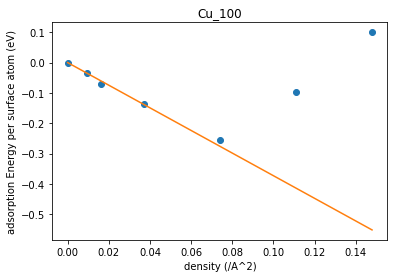

[-3.65475291]


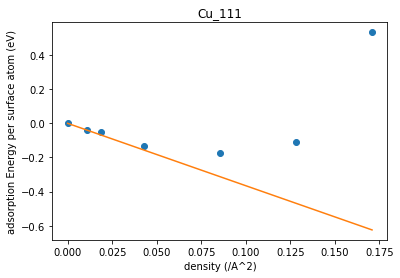

[-0.97598489]


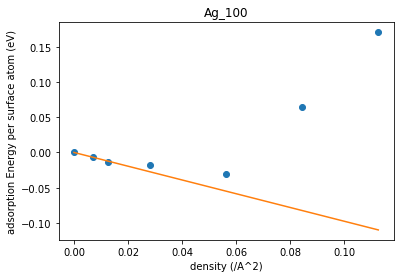

[-0.46447298]


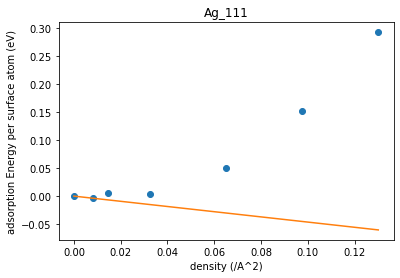

[-14.32489655]


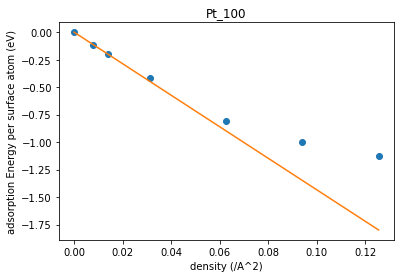

[-10.33846413]


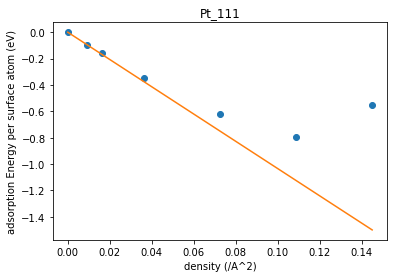

[-10.53770334]


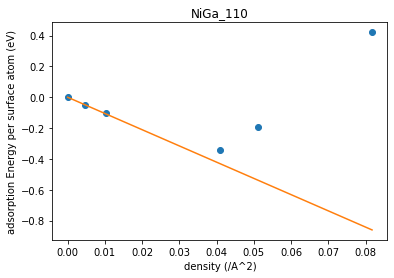

[-26.98558867]


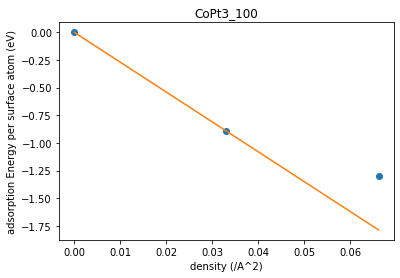

In [17]:
for i in range(len(eneset)):
    X, y = (list(x) for x in zip(*sorted(zip(densityset[i], eneset[i]))))
    X = np.array(X)
    y = np.array(y)    
    X = X.reshape(-1, 1)
    fitres, slope = linearfit2(X, y)

    print(slope)
    plt.plot(X, y, 'o')
    plt.plot(X, fitres, '-')
    plt.title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    plt.xlabel('density (/A^2)')
    plt.ylabel('adsorption Energy per surface atom (eV)')
#     plt.savefig('{}_{}_fit.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.show()

In [18]:
def func(X, slope, a2, a3, a4, a5, a6, a7, a8):
    return slope*X + a2*X**2 + a3*X**3 + a4*X**4 + a5*X**5 + a6*X**6 + a7*X**7 + a8*X**8

In [19]:
def MSE(A):
    a2, a3, a4, a5, a6, a7, a8 = A
    mse = 0
    for i in range(len(densityset)-2):
        X, y = (list(x) for x in zip(*sorted(zip(densityset[i], eneset[i]))))
        X = np.array(X)
        y = np.array(y)    
        X_ = X.reshape(-1, 1)
        fitres, slope = linearfit2(X_, y)

        mse += sum((y - func(X, slope, a2, a3, a4, a5, a6, a7, a8))**2)
    return mse

In [20]:
from scipy.optimize import minimize
sol = minimize(MSE, [1,1,1,1,1,1,1])
sol.x

array([  3.52684404, 203.88754433,  53.35825929,  11.5435298 ,
         2.9465555 ,   1.34534476,   1.0608658 ])

[-3.72801964]


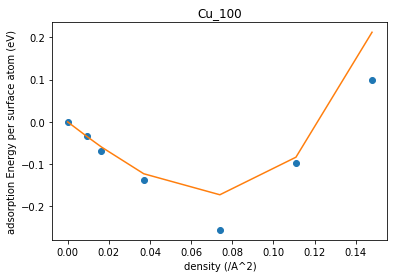

[-3.65475291]


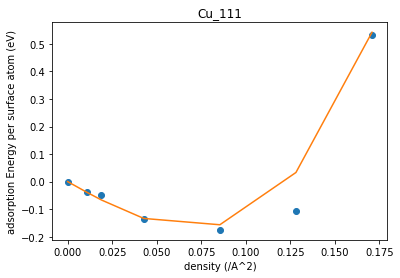

[-0.97598489]


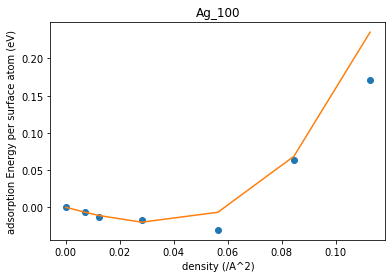

[-0.46447298]


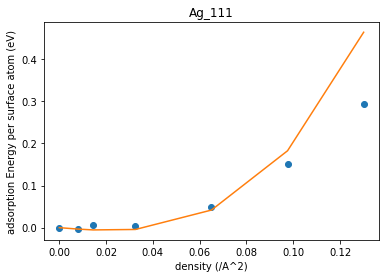

[-14.32489655]


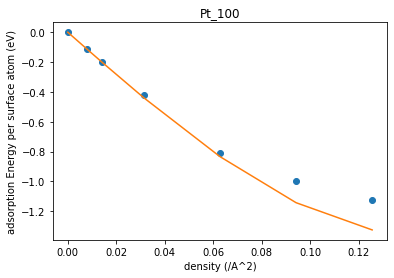

[-10.33846413]


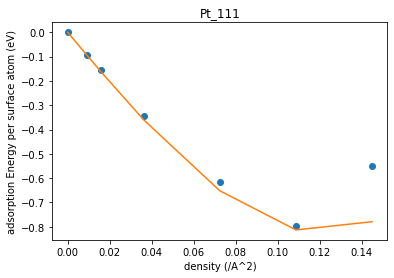

[-10.53770334]


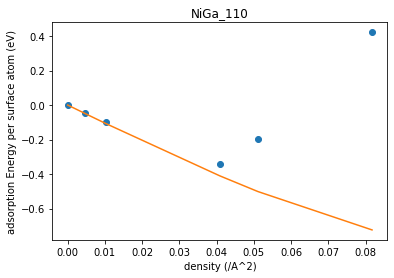

[-26.98558867]


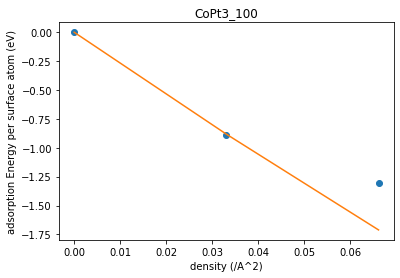

In [21]:
for i in range(len(eneset)):
    X, y = (list(x) for x in zip(*sorted(zip(densityset[i], eneset[i]))))
    X = np.array(X)
    y = np.array(y)    
    X = X.reshape(-1, 1)
    fitres, slope = linearfit2(X, y)

    print(slope)
    plt.plot(X, y, 'o')
    plt.plot(X, func(X, slope, *sol.x), '-')
    plt.title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    plt.xlabel('density (/A^2)')
    plt.ylabel('adsorption Energy per surface atom (eV)')
#     plt.savefig('{}_{}_fit.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.show()

In [22]:
import ipdb
A = df[-2][df[-2]['unitlength'] ==2]['name']

for i in A:
    ipdb.set_trace()
    init_query(i, 'local')
    query(i, 'local')

> <ipython-input-22-6187048b51d3>(6)<module>()
      5     ipdb.set_trace()
----> 6     init_query(i, 'local')
      7     query(i, 'local')

ipdb> q


BdbQuit: 

In [ ]:
df[-2][df[-2]['unitlength'] == 1]

In [ ]:
df[-2][df[-2]['unitlength'] == 2]

In [ ]:
B = df[-2][df[-2]['unitlength'] ==1][df[-2]['numberofads'] ==1]['name']

for i in B:
#     ipdb.set_trace()
    init_query(i, 'local')
    query(i, 'local')

In [ ]:
B

In [ ]:
file = 'NiGa_110_u2_no207_CO_n5_d3.traj'
file = 'NiGa_110_u1_no09_CO_n1_d3.traj'
init_query(file, 'local')
query(file, 'local')

In [ ]:
file = 'NiGa_110_u2_no384_CO_n5_d3.traj'
init_query(file, 'local')
query(file, 'local')

In [64]:
import pdb

for i in range(len(covset)):
    for j in range(len(covset[i])):
#         ipdb.set_trace()
        tmp = df[i][df[i]['coverage'] == covset[i][j]]['aveadsEne/suratom'].idxmin
        print(tmp)
        file = df[i].loc[idx[tmp]]['name']
#         print(file, i, j, tmp)
        atoms = query(file, 'spacom')
        write('{}_{}_{:0.3f}.png'.format(dictlis[i]['element'], dictlis[i]['mirror'], covset[i][j]), atoms)        

<bound method Series.idxmin of 0     0.0
4     0.0
28    0.0
32    0.0
Name: aveadsEne/suratom, dtype: float64>
<bound method Series.idxmin of 33   -0.034468
34   -0.032514
35   -0.033623
Name: aveadsEne/suratom, dtype: float64>
<bound method Series.idxmin of 29   -0.069508
30   -0.067495
31   -0.053974
Name: aveadsEne/suratom, dtype: float64>
<bound method Series.idxmin of 5    -0.137517
14   -0.121106
23   -0.099395
Name: aveadsEne/suratom, dtype: float64>
<bound method Series.idxmin of 6    -0.108000
11   -0.255473
12   -0.221327
15   -0.094458
20   -0.226275
22   -0.060141
24    0.064017
27   -0.188820
Name: aveadsEne/suratom, dtype: float64>
<bound method Series.idxmin of 7    -0.048349
9    -0.096740
13   -0.061571
16   -0.021043
18   -0.032776
21    0.118311
25    0.257283
Name: aveadsEne/suratom, dtype: float64>
<bound method Series.idxmin of 1     0.182684
2     0.201250
3     0.653586
8     0.193048
10    0.100041
17    0.204744
19    0.296433
26    0.656364
Name: aveadsEne/s

In [71]:
tmp = df[5][df[5]['numberofads'] == 4]['name']

In [80]:
file = tmp.iloc[3]
query(file, 'local')

Atoms(symbols='Pt16COCOCOCO', pbc=[True, True, False], cell=[[5.643844235708376, 0.0, 0.0], [2.821922117854188, 4.8877124831258225, 0.0], [0.0, 0.0, 26.912269282616816]], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7]), calculator=SinglePointCalculator(...))

In [76]:
tmp.iloc[0]

'Pt_111_u2_no04_CO_n4_d3.traj'